In [ ]:
# !pip3 install --no-index --find-links /kaggle/input/pycocotools-new/temporary-pycocotools pycocotools
# !pip3 install --no-index /kaggle/input/yolov8-models/yolo_wheels/ultralytics-8.0.121-py3-none-any.whl --find-links /kaggle/input/yolov8-models/yolo_wheels

In [1]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import pickle
from matplotlib import pyplot as plt

In [2]:
import cv2
import numpy as np
import base64
from pycocotools import _mask as coco_mask
import typing as t

import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool_:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)
  
  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

In [3]:
basepath = '/home/ec2-user/hubmap-hacking-the-human-vasculature'
model_path = '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/model/best.pt'
test_split_path = '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits'
model = YOLO(model_path)

In [4]:
validation_folder = '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/all_dataset1_imgs_validation_0'
labels_folder = '/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/validation_labels'

In [5]:
#splitting validation by wsi location
#using each image as seperate validation set
#using images i,j location to create a heat map

split_type = 'wsi_location'
split_type_path = f'{test_split_path}/{split_type}'
yaml_path = f'{test_split_path}/{split_type}/yamls'

if not (os.path.exists(split_type_path)):
    os.makedirs(split_type_path)  
    
if not (os.path.exists(yaml_path)):
    os.makedirs(yaml_path)
    
val_imgs = os.listdir(validation_folder)
tile_meta = pd.read_csv(f'{basepath}/tile_meta.csv')
tile_map = {}
for i in range(len(tile_meta)):
    data = tile_meta.iloc[i]
    tile_map[data['id']] = [data['i'], data['j']]

In [6]:
val_img_ids = []
for img in os.listdir(validation_folder):
    img_id = img.split('.')[0]
    val_img_ids.append(img_id)
    if not (os.path.exists(f'{split_type_path}/{img_id}')):
        os.makedirs(f'{split_type_path}/{img_id}')
        os.makedirs(f'{split_type_path}/{img_id}/images')
        os.makedirs(f'{split_type_path}/{img_id}/labels')
        shutil.copy(f'{validation_folder}/{img}', f'{split_type_path}/{img_id}/images/{img}')
        shutil.copy(f'{labels_folder}/{img_id}.txt', f'{split_type_path}/{img_id}/labels/{img_id}.txt')
    with open(f'{yaml_path}/{img_id}.yaml', 'w') as file:
        file.write(f'path: {split_type_path}\n')
        file.write(f'train: {img_id}/images\n')
        file.write(f'val: {img_id}/images\n')
        file.write('nc: 1\n')
        file.write("names: ['blood vessel']")

In [7]:
print(val_img_ids)

['00d75ad65de3', '15e5df255b86', '9afac4fc65ef', '00656c6f2690', '0e0836cf1824', 'e63d156bc72f', '0a10b8716b30', '2a577425c773', '1222b4306c01', 'a7a03dcb5485', '7ae0eb4bda2c', '7e72cf2b43bf', '65fcbb5ef4c7', 'eda294658a0a', '77c7c3714f08', 'b73efafa7477', '55eef661b175', '644a62eaaf2b', 'e283ea6e3f7b', 'cfbf75947d43', 'af587261a215', '55b07829e888', '333c1d618ae3', 'cd4b698ac682', '88c95fb9fb14', 'db20b95a3ab9', '303b72a38e29', '91170b600f70', '0c54942878fa', 'ef7f5d12b1ff', '8a6e6fb756da', '5d0731972927', '8047c43b1cb2', '214866956ea3', 'a977353c25d6', '2af27d65509c', '359bb86fa14f', 'fc6def641612', 'ed6a92a9410c', '3cf35a0393b8', 'eba1f93e5a11', 'e95c2881d1dc', '91ba77e94fd3', 'b2e28a0849fb', '212fc627af24', 'ccb2255e294d', '66bc46f89c87', 'e65fc78aa66a', '51a2ad418b22', '27661a87f456', '73d99bec414b', 'f38f2f72a1b7', '0acd70e887b3', '2ad1b19b87df', 'bb7e7fae1cf4', '8d60ccc783c1', 'e93185008c33', '7fc91238e6f8', 'a88bead7ca59', '0067d5ad2250', '465022519f3f', '9ba29448632b', 'ad4cab

In [14]:
img_scores = {}
counter = 0
counter_max = 100000
for img_id in val_img_ids:
    print(img_id)
    metrics = model.val(data=f'{yaml_path}/{img_id}.yaml')
    img_scores[img_id] = metrics.box.map
    del metrics
    counter = counter + 1
    if (counter > counter_max):
        break

Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


00d75ad65de3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/00d75ad65de3/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.413          1      0.696      0.579      0.413          1      0.696      0.577
          blood vessel          1          3      0.413          1      0.696      0.579      0.413          1      0.696      0.577
Speed: 0.4ms preprocess, 153.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val10
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


15e5df255b86


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/15e5df255b86/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4      0.735          1      0.945      0.677      0.735          1      0.945       0.62
          blood vessel          1          4      0.735          1      0.945      0.677      0.735          1      0.945       0.62
Speed: 0.4ms preprocess, 168.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val11
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


9afac4fc65ef


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/9afac4fc65ef/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.988          1      0.995      0.719      0.988          1      0.995      0.558
          blood vessel          1          6      0.988          1      0.995      0.719      0.988          1      0.995      0.558
Speed: 0.4ms preprocess, 154.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val12
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


00656c6f2690


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/00656c6f2690/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          9      0.875      0.776      0.861      0.613      0.875      0.776      0.861      0.575
          blood vessel          1          9      0.875      0.776      0.861      0.613      0.875      0.776      0.861      0.575
Speed: 0.4ms preprocess, 151.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val13
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0e0836cf1824


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0e0836cf1824/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          2      0.565          1      0.828      0.431      0.565          1      0.828      0.269
          blood vessel          1          2      0.565          1      0.828      0.431      0.565          1      0.828      0.269
Speed: 0.4ms preprocess, 155.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/val14
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e63d156bc72f


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e63d156bc72f/labels.cache... 1 images, 0 bac
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.945          1      0.995      0.406      0.945          1      0.995      0.547
          blood vessel          1          3      0.945          1      0.995      0.406      0.945          1      0.995      0.547
Speed: 0.4ms preprocess, 151.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val15
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0a10b8716b30


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0a10b8716b30/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0a10b8716b30/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4      0.943       0.75       0.87      0.373      0.943       0.75       0.87      0.412
          blood vessel          1          4      0.943       0.75       0.87      0.373      0.943       0.75       0.87      0.412
Speed: 0.4ms preprocess, 155.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val16
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


2a577425c773


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2a577425c773/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2a577425c773/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          8          1      0.731      0.867      0.516          1      0.731      0.825      0.446
          blood vessel          1          8          1      0.731      0.867      0.516          1      0.731      0.825      0.446
Speed: 0.4ms preprocess, 153.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val17
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


1222b4306c01


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/1222b4306c01/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/1222b4306c01/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.741      0.964      0.913      0.583      0.741      0.964      0.913      0.616
          blood vessel          1          3      0.741      0.964      0.913      0.583      0.741      0.964      0.913      0.616
Speed: 0.4ms preprocess, 154.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val18
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


a7a03dcb5485


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a7a03dcb5485/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a7a03dcb5485/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.324      0.667      0.377      0.249      0.324      0.667      0.377       0.25
          blood vessel          1          3      0.324      0.667      0.377      0.249      0.324      0.667      0.377       0.25
Speed: 0.4ms preprocess, 158.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val19
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


7ae0eb4bda2c


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7ae0eb4bda2c/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7ae0eb4bda2c/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4       0.98          1      0.995      0.573       0.98          1      0.995      0.585
          blood vessel          1          4       0.98          1      0.995      0.573       0.98          1      0.995      0.585
Speed: 0.4ms preprocess, 154.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val20
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


7e72cf2b43bf


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7e72cf2b43bf/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7e72cf2b43bf/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.975          1      0.995      0.569      0.975          1      0.995      0.536
          blood vessel          1          3      0.975          1      0.995      0.569      0.975          1      0.995      0.536
Speed: 0.4ms preprocess, 157.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val21
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


65fcbb5ef4c7


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/65fcbb5ef4c7/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/65fcbb5ef4c7/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4      0.748       0.75      0.793        0.7      0.748       0.75      0.793      0.356
          blood vessel          1          4      0.748       0.75      0.793        0.7      0.748       0.75      0.793      0.356
Speed: 0.4ms preprocess, 153.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val22
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


eda294658a0a


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/eda294658a0a/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/eda294658a0a/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          8      0.816      0.625      0.778      0.503      0.986       0.75      0.926       0.53
          blood vessel          1          8      0.816      0.625      0.778      0.503      0.986       0.75      0.926       0.53
Speed: 0.4ms preprocess, 155.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val23
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


77c7c3714f08


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/77c7c3714f08/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/77c7c3714f08/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          8      0.832      0.618      0.746      0.424          1      0.739      0.778      0.443
          blood vessel          1          8      0.832      0.618      0.746      0.424          1      0.739      0.778      0.443
Speed: 0.4ms preprocess, 160.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val24
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


b73efafa7477


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b73efafa7477/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b73efafa7477/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.643      0.618      0.617      0.366      0.643      0.618      0.617      0.392
          blood vessel          1          3      0.643      0.618      0.617      0.366      0.643      0.618      0.617      0.392
Speed: 3.1ms preprocess, 163.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/val25
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


55eef661b175


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55eef661b175/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55eef661b175/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.735          1      0.913      0.649      0.735          1      0.913      0.649
          blood vessel          1          3      0.735          1      0.913      0.649      0.735          1      0.913      0.649
Speed: 0.4ms preprocess, 155.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val26
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


644a62eaaf2b


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/644a62eaaf2b/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/644a62eaaf2b/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.978      0.667      0.666      0.468      0.978      0.667      0.666      0.468
          blood vessel          1          3      0.978      0.667      0.666      0.468      0.978      0.667      0.666      0.468
Speed: 0.4ms preprocess, 160.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/val27
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e283ea6e3f7b


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e283ea6e3f7b/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e283ea6e3f7b/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.711          1      0.913      0.541      0.711          1      0.913      0.474
          blood vessel          1          3      0.711          1      0.913      0.541      0.711          1      0.913      0.474
Speed: 0.4ms preprocess, 153.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val28
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


cfbf75947d43


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/cfbf75947d43/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/cfbf75947d43/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          5          1      0.779      0.962      0.647          1      0.779      0.851      0.644
          blood vessel          1          5          1      0.779      0.962      0.647          1      0.779      0.851      0.644
Speed: 0.4ms preprocess, 159.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/val29
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


af587261a215


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/af587261a215/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/af587261a215/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          5      0.436        0.8      0.573      0.425      0.436        0.8      0.573      0.377
          blood vessel          1          5      0.436        0.8      0.573      0.425      0.436        0.8      0.573      0.377
Speed: 0.4ms preprocess, 152.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val30
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


55b07829e888


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55b07829e888/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55b07829e888/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.745      0.974      0.879      0.692      0.745      0.974      0.879      0.625
          blood vessel          1          6      0.745      0.974      0.879      0.692      0.745      0.974      0.879      0.625
Speed: 0.4ms preprocess, 157.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val31
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


333c1d618ae3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/333c1d618ae3/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/333c1d618ae3/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4      0.956          1      0.995      0.687      0.956          1      0.995      0.667
          blood vessel          1          4      0.956          1      0.995      0.687      0.956          1      0.995      0.667
Speed: 0.4ms preprocess, 161.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val32
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


cd4b698ac682


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/cd4b698ac682/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/cd4b698ac682/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          7      0.684          1      0.913      0.636      0.684          1      0.913       0.57
          blood vessel          1          7      0.684          1      0.913      0.636      0.684          1      0.913       0.57
Speed: 0.4ms preprocess, 158.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val33
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


88c95fb9fb14


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/88c95fb9fb14/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/88c95fb9fb14/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.484      0.333      0.432      0.298      0.486      0.667      0.641      0.304
          blood vessel          1          3      0.484      0.333      0.432      0.298      0.486      0.667      0.641      0.304
Speed: 0.4ms preprocess, 174.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val34
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


db20b95a3ab9


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/db20b95a3ab9/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/db20b95a3ab9/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.855          1      0.948      0.734      0.855          1      0.948      0.685
          blood vessel          1          6      0.855          1      0.948      0.734      0.855          1      0.948      0.685
Speed: 0.4ms preprocess, 160.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val35
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


303b72a38e29


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/303b72a38e29/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/303b72a38e29/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          2      0.945          1      0.995      0.995      0.945          1      0.995      0.895
          blood vessel          1          2      0.945          1      0.995      0.995      0.945          1      0.995      0.895
Speed: 0.4ms preprocess, 164.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val36
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


91170b600f70


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/91170b600f70/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/91170b600f70/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.972          1      0.995      0.648      0.972          1      0.995      0.511
          blood vessel          1          3      0.972          1      0.995      0.648      0.972          1      0.995      0.511
Speed: 0.4ms preprocess, 161.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val37
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0c54942878fa


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0c54942878fa/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0c54942878fa/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          5      0.939          1      0.995      0.602      0.939          1      0.995       0.59
          blood vessel          1          5      0.939          1      0.995      0.602      0.939          1      0.995       0.59
Speed: 0.4ms preprocess, 156.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val38
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


ef7f5d12b1ff


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ef7f5d12b1ff/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ef7f5d12b1ff/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         10      0.872        0.8      0.831      0.571      0.872        0.8        0.8      0.523
          blood vessel          1         10      0.872        0.8      0.831      0.571      0.872        0.8        0.8      0.523
Speed: 0.7ms preprocess, 166.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val39
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


8a6e6fb756da


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8a6e6fb756da/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8a6e6fb756da/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          2      0.307        0.5      0.224      0.172      0.307        0.5      0.185      0.102
          blood vessel          1          2      0.307        0.5      0.224      0.172      0.307        0.5      0.185      0.102
Speed: 0.4ms preprocess, 167.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val40
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


5d0731972927


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/5d0731972927/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/5d0731972927/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          7      0.772      0.714      0.756      0.506      0.772      0.714      0.756      0.529
          blood vessel          1          7      0.772      0.714      0.756      0.506      0.772      0.714      0.756      0.529
Speed: 0.4ms preprocess, 159.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val41
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


8047c43b1cb2


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8047c43b1cb2/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8047c43b1cb2/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4      0.874          1      0.995      0.684      0.874          1      0.995      0.647
          blood vessel          1          4      0.874          1      0.995      0.684      0.874          1      0.995      0.647
Speed: 0.4ms preprocess, 154.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/val42
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


214866956ea3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/214866956ea3/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/214866956ea3/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          4          1      0.471      0.613      0.403          1      0.471       0.59      0.369
          blood vessel          1          4          1      0.471      0.613      0.403          1      0.471       0.59      0.369
Speed: 0.4ms preprocess, 163.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/val43
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


a977353c25d6


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a977353c25d6/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a977353c25d6/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          5      0.656      0.768      0.687      0.507      0.656      0.768      0.687      0.493
          blood vessel          1          5      0.656      0.768      0.687      0.507      0.656      0.768      0.687      0.493
Speed: 0.4ms preprocess, 155.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val44
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


2af27d65509c


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2af27d65509c/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2af27d65509c/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.419          1      0.474      0.351      0.419          1      0.474      0.374
          blood vessel          1          3      0.419          1      0.474      0.351      0.419          1      0.474      0.374
Speed: 0.4ms preprocess, 161.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val45
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


359bb86fa14f


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/359bb86fa14f/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/359bb86fa14f/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         11      0.908      0.894      0.887      0.702      0.908      0.894      0.884      0.624
          blood vessel          1         11      0.908      0.894      0.887      0.702      0.908      0.894      0.884      0.624
Speed: 0.4ms preprocess, 161.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/val46
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


fc6def641612


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/fc6def641612/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/fc6def641612/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.871      0.333      0.475      0.281      0.871      0.333      0.475      0.344
          blood vessel          1          3      0.871      0.333      0.475      0.281      0.871      0.333      0.475      0.344
Speed: 0.4ms preprocess, 162.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val47
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


ed6a92a9410c


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ed6a92a9410c/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ed6a92a9410c/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          9      0.982      0.889      0.888        0.6      0.982      0.889      0.888      0.568
          blood vessel          1          9      0.982      0.889      0.888        0.6      0.982      0.889      0.888      0.568
Speed: 0.4ms preprocess, 153.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val48
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


3cf35a0393b8


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3cf35a0393b8/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3cf35a0393b8/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.459      0.667      0.522       0.25      0.736        0.5       0.56      0.242
          blood vessel          1          6      0.459      0.667      0.522       0.25      0.736        0.5       0.56      0.242
Speed: 0.4ms preprocess, 161.9ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/val49
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


eba1f93e5a11


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/eba1f93e5a11/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/eba1f93e5a11/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          2      0.373        0.5      0.324       0.23      0.373        0.5      0.324      0.212
          blood vessel          1          2      0.373        0.5      0.324       0.23      0.373        0.5      0.324      0.212
Speed: 0.4ms preprocess, 155.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/val50
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e95c2881d1dc


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e95c2881d1dc/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e95c2881d1dc/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.975      0.833      0.839        0.5      0.975      0.833      0.839      0.489
          blood vessel          1          6      0.975      0.833      0.839        0.5      0.975      0.833      0.839      0.489
Speed: 0.4ms preprocess, 155.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val51
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


91ba77e94fd3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/91ba77e94fd3/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/91ba77e94fd3/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         11      0.437      0.545       0.35      0.122      0.437      0.545       0.35      0.122
          blood vessel          1         11      0.437      0.545       0.35      0.122      0.437      0.545       0.35      0.122
Speed: 0.4ms preprocess, 160.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/val52
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


b2e28a0849fb


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b2e28a0849fb/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b2e28a0849fb/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         34      0.937       0.44      0.673      0.367      0.937       0.44      0.673      0.357
          blood vessel          1         34      0.937       0.44      0.673      0.367      0.937       0.44      0.673      0.357
Speed: 0.4ms preprocess, 164.3ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/segment/val53
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


212fc627af24


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/212fc627af24/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/212fc627af24/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         15      0.663        0.8      0.702      0.289      0.703      0.867      0.743      0.295
          blood vessel          1         15      0.663        0.8      0.702      0.289      0.703      0.867      0.743      0.295
Speed: 0.4ms preprocess, 158.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/val54
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


ccb2255e294d


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ccb2255e294d/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ccb2255e294d/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         36      0.668      0.672      0.729       0.35      0.695      0.697       0.73       0.33
          blood vessel          1         36      0.668      0.672      0.729       0.35      0.695      0.697       0.73       0.33
Speed: 0.4ms preprocess, 167.8ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to runs/segment/val55
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


66bc46f89c87


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/66bc46f89c87/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/66bc46f89c87/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         13      0.745      0.308      0.423      0.249      0.931      0.385      0.533      0.223
          blood vessel          1         13      0.745      0.308      0.423      0.249      0.931      0.385      0.533      0.223
Speed: 0.5ms preprocess, 165.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/val56
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e65fc78aa66a


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e65fc78aa66a/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e65fc78aa66a/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          9      0.455      0.556      0.519      0.311      0.455      0.556      0.473       0.21
          blood vessel          1          9      0.455      0.556      0.519      0.311      0.455      0.556      0.473       0.21
Speed: 0.4ms preprocess, 161.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/val57
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


51a2ad418b22


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/51a2ad418b22/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/51a2ad418b22/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         20      0.828        0.8      0.809      0.374      0.828        0.8      0.806      0.324
          blood vessel          1         20      0.828        0.8      0.809      0.374      0.828        0.8      0.806      0.324
Speed: 0.4ms preprocess, 166.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/val58
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


27661a87f456


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/27661a87f456/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/27661a87f456/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         10       0.57      0.796      0.607      0.357       0.57      0.796      0.607      0.217
          blood vessel          1         10       0.57      0.796      0.607      0.357       0.57      0.796      0.607      0.217
Speed: 0.4ms preprocess, 161.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/val59
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


73d99bec414b


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/73d99bec414b/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/73d99bec414b/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         13       0.48      0.615      0.583      0.318      0.454      0.832      0.629      0.229
          blood vessel          1         13       0.48      0.615      0.583      0.318      0.454      0.832      0.629      0.229
Speed: 0.4ms preprocess, 158.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/val60
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


f38f2f72a1b7


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/f38f2f72a1b7/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/f38f2f72a1b7/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         40      0.777      0.825       0.83       0.47      0.777      0.825       0.83      0.456
          blood vessel          1         40      0.777      0.825       0.83       0.47      0.777      0.825       0.83      0.456
Speed: 0.4ms preprocess, 159.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/val61
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0acd70e887b3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0acd70e887b3/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0acd70e887b3/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         12      0.709       0.25      0.407      0.201      0.454      0.583       0.51      0.176
          blood vessel          1         12      0.709       0.25      0.407      0.201      0.454      0.583       0.51      0.176
Speed: 0.4ms preprocess, 161.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/val62
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


2ad1b19b87df


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2ad1b19b87df/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2ad1b19b87df/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         11      0.799      0.362      0.454      0.174      0.799      0.362      0.411      0.163
          blood vessel          1         11      0.799      0.362      0.454      0.174      0.799      0.362      0.411      0.163
Speed: 0.4ms preprocess, 164.0ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/val63
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


bb7e7fae1cf4


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/bb7e7fae1cf4/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/bb7e7fae1cf4/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          3      0.231      0.333      0.124     0.0483      0.231      0.333      0.112      0.043
          blood vessel          1          3      0.231      0.333      0.124     0.0483      0.231      0.333      0.112      0.043
Speed: 0.4ms preprocess, 161.2ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/val64
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


8d60ccc783c1


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8d60ccc783c1/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8d60ccc783c1/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          7      0.461      0.857      0.517      0.294      0.461      0.857      0.517      0.253
          blood vessel          1          7      0.461      0.857      0.517      0.294      0.461      0.857      0.517      0.253
Speed: 0.4ms preprocess, 162.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/val65
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e93185008c33


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e93185008c33/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e93185008c33/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          8      0.652        0.5      0.462      0.202      0.652        0.5      0.495      0.246
          blood vessel          1          8      0.652        0.5      0.462      0.202      0.652        0.5      0.495      0.246
Speed: 0.4ms preprocess, 160.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/val66
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


7fc91238e6f8


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7fc91238e6f8/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7fc91238e6f8/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         19      0.551      0.842      0.694        0.3      0.567      0.757      0.713      0.281
          blood vessel          1         19      0.551      0.842      0.694        0.3      0.567      0.757      0.713      0.281
Speed: 1.9ms preprocess, 163.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/val67
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


a88bead7ca59


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a88bead7ca59/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a88bead7ca59/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         14      0.571       0.57      0.564      0.334      0.701      0.357      0.501        0.3
          blood vessel          1         14      0.571       0.57      0.564      0.334      0.701      0.357      0.501        0.3
Speed: 0.4ms preprocess, 162.5ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/segment/val68
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0067d5ad2250


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0067d5ad2250/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0067d5ad2250/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.469        0.5      0.459      0.246      0.469        0.5      0.452      0.179
          blood vessel          1          6      0.469        0.5      0.459      0.246      0.469        0.5      0.452      0.179
Speed: 0.4ms preprocess, 157.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/val69
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


465022519f3f


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/465022519f3f/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/465022519f3f/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         12      0.639       0.75      0.695      0.336      0.604      0.667      0.644      0.273
          blood vessel          1         12      0.639       0.75      0.695      0.336      0.604      0.667      0.644      0.273
Speed: 0.4ms preprocess, 164.3ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/val70
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


9ba29448632b


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/9ba29448632b/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/9ba29448632b/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         13      0.749      0.615      0.627       0.31      0.857      0.692      0.748      0.328
          blood vessel          1         13      0.749      0.615      0.627       0.31      0.857      0.692      0.748      0.328
Speed: 0.4ms preprocess, 162.1ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/segment/val71
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


ad4cabec2278


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ad4cabec2278/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/ad4cabec2278/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         11      0.555      0.818      0.689      0.345      0.555      0.818      0.689      0.383
          blood vessel          1         11      0.555      0.818      0.689      0.345      0.555      0.818      0.689      0.383
Speed: 0.4ms preprocess, 166.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/val72
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


a65fdd745f6f


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a65fdd745f6f/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a65fdd745f6f/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.723        0.5      0.574      0.277      0.723        0.5      0.574       0.33
          blood vessel          1          6      0.723        0.5      0.574      0.277      0.723        0.5      0.574       0.33
Speed: 0.4ms preprocess, 162.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/val73
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


3879b8c84baf


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3879b8c84baf/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3879b8c84baf/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          7      0.365      0.714      0.336      0.117      0.442      0.857      0.441      0.155
          blood vessel          1          7      0.365      0.714      0.336      0.117      0.442      0.857      0.441      0.155
Speed: 0.4ms preprocess, 161.8ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/val74
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


d3bab0895723


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/d3bab0895723/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/d3bab0895723/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         12      0.469      0.667      0.549      0.337      0.469      0.667      0.532      0.288
          blood vessel          1         12      0.469      0.667      0.549      0.337      0.469      0.667      0.532      0.288
Speed: 0.4ms preprocess, 162.1ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/val75
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


5232ba7fa001


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/5232ba7fa001/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/5232ba7fa001/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         31      0.916      0.839      0.916       0.41      0.916      0.839      0.909      0.325
          blood vessel          1         31      0.916      0.839      0.916       0.41      0.916      0.839      0.909      0.325
Speed: 0.4ms preprocess, 160.0ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/val76
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


602d24899028


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/602d24899028/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/602d24899028/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          6      0.279      0.833      0.266      0.077      0.226      0.667      0.195     0.0814
          blood vessel          1          6      0.279      0.833      0.266      0.077      0.226      0.667      0.195     0.0814
Speed: 0.4ms preprocess, 156.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/val77
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


55cab2c9c13a


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55cab2c9c13a/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/55cab2c9c13a/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          1      0.868          1      0.995      0.697      0.868          1      0.995      0.298
          blood vessel          1          1      0.868          1      0.995      0.697      0.868          1      0.995      0.298
Speed: 0.4ms preprocess, 158.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/val78
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


939c99c1e09a


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/939c99c1e09a/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/939c99c1e09a/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         17      0.423      0.588      0.407       0.17      0.552      0.653      0.621      0.238
          blood vessel          1         17      0.423      0.588      0.407       0.17      0.552      0.653      0.621      0.238
Speed: 0.4ms preprocess, 158.1ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/segment/val79
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


0c3086bd8efb


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0c3086bd8efb/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/0c3086bd8efb/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         20      0.793        0.5      0.663      0.294      0.581      0.762      0.686       0.25
          blood vessel          1         20      0.793        0.5      0.663      0.294      0.581      0.762      0.686       0.25
Speed: 0.4ms preprocess, 161.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/val80
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


e3c41ad419a2


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e3c41ad419a2/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/e3c41ad419a2/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         10      0.476        0.7      0.571      0.255      0.476        0.7      0.582      0.217
          blood vessel          1         10      0.476        0.7      0.571      0.255      0.476        0.7      0.582      0.217
Speed: 0.4ms preprocess, 158.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/val81
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


3378fe495259


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3378fe495259/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/3378fe495259/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         12      0.524      0.667      0.572      0.245      0.524      0.667      0.572      0.159
          blood vessel          1         12      0.524      0.667      0.572      0.245      0.524      0.667      0.572      0.159
Speed: 0.4ms preprocess, 155.6ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/val82
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


61409556c001


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/61409556c001/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/61409556c001/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         18      0.646      0.711      0.696       0.32      0.696      0.762      0.783      0.375
          blood vessel          1         18      0.646      0.711      0.696       0.32      0.696      0.762      0.783      0.375
Speed: 0.4ms preprocess, 159.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/val83
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


b9026c35238c


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b9026c35238c/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/b9026c35238c/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         30      0.856      0.596      0.773      0.348      0.904      0.627      0.797      0.326
          blood vessel          1         30      0.856      0.596      0.773      0.348      0.904      0.627      0.797      0.326
Speed: 0.4ms preprocess, 157.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/val84
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


2a4cc81cc5d6


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2a4cc81cc5d6/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/2a4cc81cc5d6/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         16      0.745       0.75       0.75      0.438      0.738      0.704      0.766      0.441
          blood vessel          1         16      0.745       0.75       0.75      0.438      0.738      0.704      0.766      0.441
Speed: 0.4ms preprocess, 172.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/val85
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


8f4c08f55c0f


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8f4c08f55c0f/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/8f4c08f55c0f/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         28      0.774      0.643      0.658      0.332      0.774      0.643      0.694       0.33
          blood vessel          1         28      0.774      0.643      0.658      0.332      0.774      0.643      0.694       0.33
Speed: 0.4ms preprocess, 163.2ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/val86
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


c956a02b5d22


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/c956a02b5d22/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/c956a02b5d22/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          9      0.332      0.333      0.334      0.179      0.553      0.444      0.401      0.165
          blood vessel          1          9      0.332      0.333      0.334      0.179      0.553      0.444      0.401      0.165
Speed: 1.0ms preprocess, 166.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/val87
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


c72da07dc0ee


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/c72da07dc0ee/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/c72da07dc0ee/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         16      0.772      0.635      0.749      0.372      0.848      0.699      0.785      0.427
          blood vessel          1         16      0.772      0.635      0.749      0.372      0.848      0.699      0.785      0.427
Speed: 0.4ms preprocess, 161.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/val88
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


4ca084aec87b


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/4ca084aec87b/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/4ca084aec87b/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         19      0.697      0.421      0.453      0.266      0.697      0.421      0.481      0.269
          blood vessel          1         19      0.697      0.421      0.453      0.266      0.697      0.421      0.481      0.269
Speed: 0.4ms preprocess, 160.5ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/segment/val89
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


a3926b1211d3


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a3926b1211d3/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/a3926b1211d3/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         13      0.888      0.846      0.816      0.366      0.888      0.846      0.816      0.406
          blood vessel          1         13      0.888      0.846      0.816      0.366      0.888      0.846      0.816      0.406
Speed: 0.4ms preprocess, 155.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/val90
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


7e97ecdac5d2


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7e97ecdac5d2/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/7e97ecdac5d2/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1          9      0.553      0.444      0.488      0.337      0.701      0.556      0.614      0.368
          blood vessel          1          9      0.553      0.444      0.488      0.337      0.701      0.556      0.614      0.368
Speed: 0.4ms preprocess, 160.4ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/val91
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


92394add7fb2


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/92394add7fb2/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/92394add7fb2/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         11      0.937      0.455      0.554      0.336      0.878      0.455      0.638      0.323
          blood vessel          1         11      0.937      0.455      0.554      0.336      0.878      0.455      0.638      0.323
Speed: 0.4ms preprocess, 168.5ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/val92
Ultralytics YOLOv8.0.121 🚀 Python-3.10.11 torch-2.0.1+cu117 CPU


84d81e7b03c1


val: Scanning /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/84d81e7b03c1/labels... 1 images, 0 backgroun
val: New cache created: /home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/data/test_splits/wsi_location/84d81e7b03c1/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/
                   all          1         17      0.894      0.588      0.783      0.441      0.894      0.588      0.783      0.323
          blood vessel          1         17      0.894      0.588      0.783      0.441      0.894      0.588      0.783      0.323
Speed: 0.4ms preprocess, 164.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/val93


In [15]:
print(img_scores)

{'00d75ad65de3': 0.5787953571428573, '15e5df255b86': 0.6771766666666668, '9afac4fc65ef': 0.71854140625, '00656c6f2690': 0.6130217209383754, '0e0836cf1824': 0.4308333333333333, 'e63d156bc72f': 0.40647818181818185, '0a10b8716b30': 0.37289777296628523, '2a577425c773': 0.5155949829734755, '1222b4306c01': 0.5832868413646946, 'a7a03dcb5485': 0.24877873643632215, '7ae0eb4bda2c': 0.5729755351681958, '7e72cf2b43bf': 0.5687079664685908, '65fcbb5ef4c7': 0.6997038610038608, 'eda294658a0a': 0.5026216156651981, '77c7c3714f08': 0.4242418761965444, 'b73efafa7477': 0.36571642820512823, '55eef661b175': 0.6485375806451613, '644a62eaaf2b': 0.4681121000000001, 'e283ea6e3f7b': 0.5407109042553192, 'cfbf75947d43': 0.646758141762452, 'af587261a215': 0.4250688119970354, '55b07829e888': 0.6920770028763185, '333c1d618ae3': 0.6865224820143885, 'cd4b698ac682': 0.636110268487551, '88c95fb9fb14': 0.29808845077220075, 'db20b95a3ab9': 0.7337908284023669, '303b72a38e29': 0.9949999999999999, '91170b600f70': 0.64835863636

In [7]:
output_path = "/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/results/test_splits"
results_path = "/home/ec2-user/hubmap-hacking-the-human-vasculature/project_yolo/results/test_splits/wsi_location/results.pkl"


In [ ]:
# Write the dictionary to the pickle file
with open(results_path, 'wb') as file:
    pickle.dump(img_scores, file)

In [8]:
with open(results_path, 'rb') as file:
    results = pickle.load(file)

In [9]:
print(results)

{'00d75ad65de3': 0.5787953571428573, '15e5df255b86': 0.6771766666666668, '9afac4fc65ef': 0.71854140625, '00656c6f2690': 0.6130217209383754, '0e0836cf1824': 0.4308333333333333, 'e63d156bc72f': 0.40647818181818185, '0a10b8716b30': 0.37289777296628523, '2a577425c773': 0.5155949829734755, '1222b4306c01': 0.5832868413646946, 'a7a03dcb5485': 0.24877873643632215, '7ae0eb4bda2c': 0.5729755351681958, '7e72cf2b43bf': 0.5687079664685908, '65fcbb5ef4c7': 0.6997038610038608, 'eda294658a0a': 0.5026216156651981, '77c7c3714f08': 0.4242418761965444, 'b73efafa7477': 0.36571642820512823, '55eef661b175': 0.6485375806451613, '644a62eaaf2b': 0.4681121000000001, 'e283ea6e3f7b': 0.5407109042553192, 'cfbf75947d43': 0.646758141762452, 'af587261a215': 0.4250688119970354, '55b07829e888': 0.6920770028763185, '333c1d618ae3': 0.6865224820143885, 'cd4b698ac682': 0.636110268487551, '88c95fb9fb14': 0.29808845077220075, 'db20b95a3ab9': 0.7337908284023669, '303b72a38e29': 0.9949999999999999, '91170b600f70': 0.64835863636

In [21]:
i_max = int(tile_meta['i'].max()/512)
j_max = int(tile_meta['j'].max()/512)
print(i_max, j_max)

59 103


In [24]:
tile_meta.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [25]:
tile_meta = pd.read_csv(f'{basepath}/tile_meta.csv')
tile_wsi = {}
for i in range(len(tile_meta)):
    data = tile_meta.iloc[i]
    tile_wsi[data['id']] = data['source_wsi']

In [27]:
print(set(tile_wsi.values()))

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14}


(array([1, 2]), array([1, 2]))
1 2 1 2


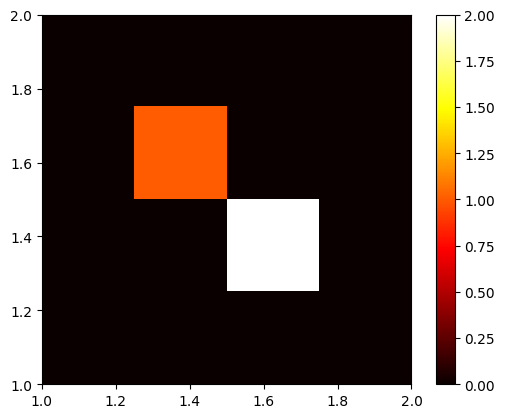

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample 2D array with zero values
data = np.array([[0, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 2, 0],
                 [0, 0, 0, 0]])

# Get the dimensions of the non-zero region
nonzero_indices = np.nonzero(data)
xmin, xmax = np.min(nonzero_indices[1]), np.max(nonzero_indices[1])
ymin, ymax = np.min(nonzero_indices[0]), np.max(nonzero_indices[0])
print(nonzero_indices)
print(xmin, xmax,ymin, ymax)
# Plot the heatmap
plt.imshow(data, cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])

# Add colorbar
plt.colorbar()

# Show the plot
plt.show()


1


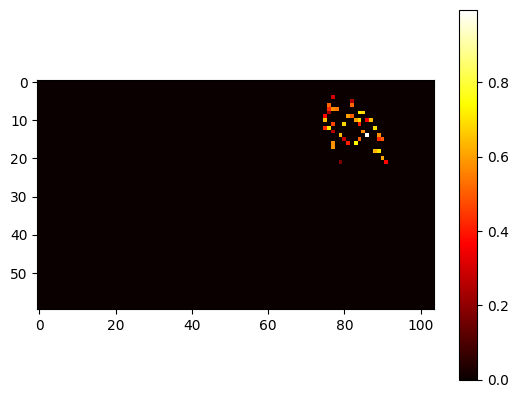

2


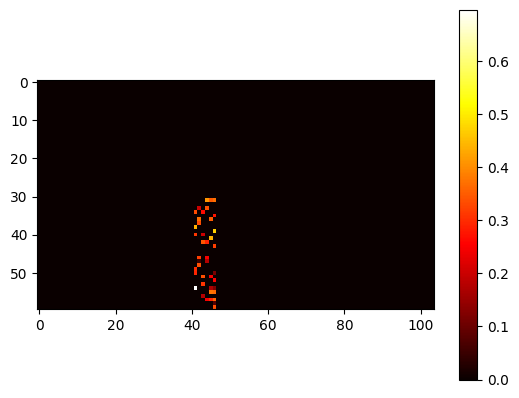

In [36]:
val_wsis = {}
for img_id in val_img_ids:
    wsi = tile_wsi[img_id]
    if wsi in val_wsis:
        val_wsis[wsi].append(img_id)
    else:
        val_wsis[wsi] = [img_id]
for val_wsi in val_wsis:
    print(val_wsi)
    score_matrix = np.zeros((i_max + 1, j_max + 1))
    for img_id in val_wsis[val_wsi]:
        x = int(tile_map[img_id][0]/512)
        y = int(tile_map[img_id][1]/512)
        score = results[img_id]
        score_matrix[x,y] = score
    plt.imshow(score_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
        

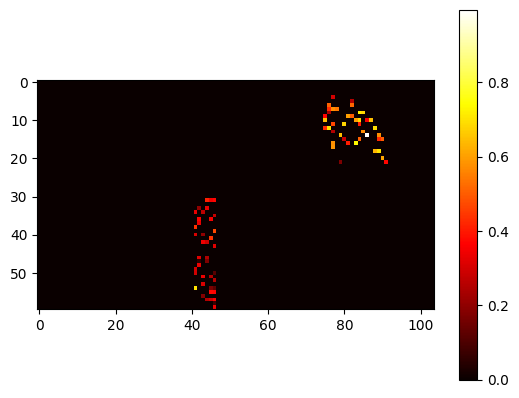

In [23]:
plt.imshow(score_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
import time
def generate_submission(model, validation_folder, conf=0.001):
    submission_dicts = []
    start_time = time.time()
    validation_list = os.listdir(validation_folder)
    all_classes = set()
    for idx, file_name in enumerate(validation_list):
        cur_dict = dict()
        img_id = file_name.split('.')[0]
        cur_dict['id'] = img_id
        im = cv2.imread(f'{validation_folder}/{file_name}')
        height, width = im.shape[:2]
        cur_dict['height'] = height
        cur_dict['width'] = width
        results = model(f'{validation_folder}/{file_name}', conf=conf)
        prediction_string = ''
        boxes = results[0].boxes
        masks = results[0].masks
        for i in range(len(boxes)):
            box = boxes[i]
            mask = masks[i]
            cur_category = int(box.cls.item())
            confidence = box.conf
            if cur_category == 0:
                polygon_mask_string = encode_binary_mask(np.array(mask.data[0,:,:].cpu(), dtype=bool)).decode('utf-8')
                prediction_string += f'{cur_category} {confidence.item()} {polygon_mask_string} '
        cur_dict['prediction_string'] = prediction_string.strip()
        submission_dicts.append(cur_dict)
        if (idx+1) % 500 == 0:
            print(f'On batch {idx} and finished in {float(time.time()-start_time)/60} minutes')
    submission_df = pd.DataFrame.from_dict(submission_dicts)
    submission_df.to_csv(f'submission.csv', index=False)

In [ ]:
generate_submission(model, validation_folder)